# How to weaponize the randomness of k-means

## Introduction: The Problem

A typical introductory text about the k-means algorithm will state that one of the main issues in using this algorithm is that the user has to set the number of clusters beforehand. **Never mind the number of clusters: How do you know if your data actually has any structure at all?** If the probability distributions underlying your dataset (sometimes called the "data generating distributions") do not have any cluster structure, then any solution found by the k-means algorithm will be completely random. Even if your data has structure, then generally multiple runs of k-means will not produce identical clusterings.

In this notebook I will show a way to use this randomness of clusterings found by k-means to identify whether your data has cluster structure and how many clusters k-means can reasonably find.

I'll start with an example of how a dataset with two unrelated and normally distributed features leads to random solutions.

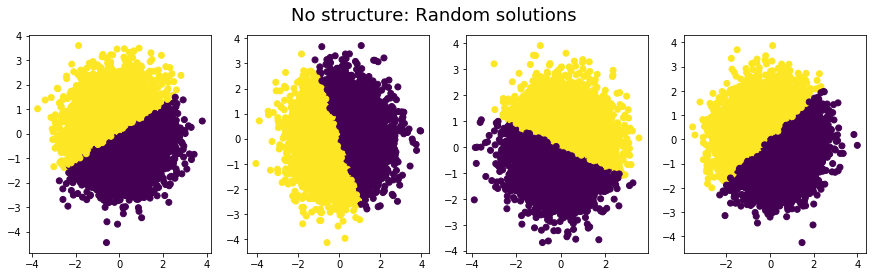

In [2]:
%matplotlib inline

import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

n = 10000

def genNormalData(n):
    x = []
    for xi in range(n):
        x.append(normal())
    return x

fig = plt.gcf()
fig.suptitle("No structure: Random solutions", fontsize=18)
fig.set_figheight(4)
fig.set_figwidth(15)

# Just so this notebook is exactly reproducible:
np.random.seed(0)

for i in range(4):
    x1 = genNormalData(n)
    x2 = genNormalData(n)
    X = np.array([x1, x2]).T 
    kmeans = KMeans(2, init='random')
    clusters = kmeans.fit_predict(X)
    plt.subplot(141 + i)
    plt.scatter(x1, x2, c=clusters)

In real life, you're unlikely to be able to conveniently visualize your data like I've done here. So we're going to need a more algorithmic approach to figuring out if your solution is random and if your data has any structure to it. So let's generate a toy dataset that we can play with.

## A Toy Dataset With Some Structure

To investigate some possible approaches that may work to identify random solutions and/or structure, let's take a look at this dataset, with four clusters with uniformly distributed datapoints.


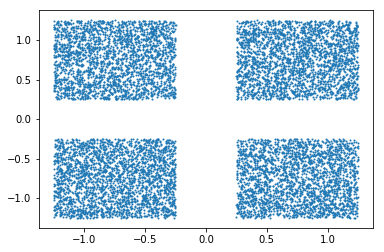

In [3]:
import numpy as np
from numpy.random import uniform

def gen(n, l=1, split=True):
    x = []
    for xi in range(n):
        r = uniform() * 2 - 1
        if r > 0:
            r = r + 0.25
        else:
            r = r - 0.25
        x.append(r)
    return x

# Just so this notebook is exactly reproducible:
np.random.seed(0)

x = gen(n)
y = gen(n)
plt.scatter(x, y, s=1)

## Running K-Means on the Toy

From the visuailzations it's obvious that this dataset has 4 clusters, but of course in practical situations, this will not be so obvious. Let's see what happens when we try to cluster this dataset with 2, 3, 4 or 5 clusters.

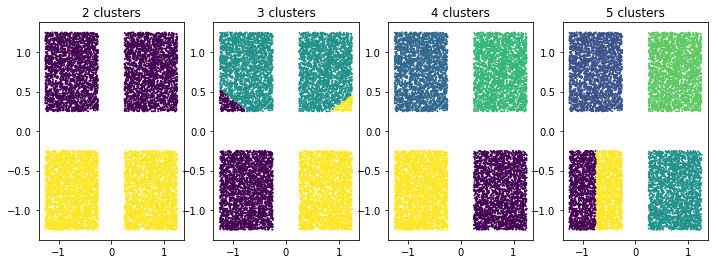

In [4]:
import matplotlib.pyplot as plt

X = np.array([x, y]).T 

plt.figure(1, figsize=(12, 4))

for i in range(4):
    k = 2 + i
    kmeans = KMeans(k, init='random')
    clusters = kmeans.fit_predict(X)    
    plt.subplot(141 + i)
    plt.title(str(k)+ " clusters")
    plt.scatter(x, y, c=clusters, s=1)

If we look at any of these clusterings, all except for the solution with 4 clusters are random. The solution with 2 clusters could randomly join both left and right clusters, or it could form a cluster of the top squares and another cluster containing the bottom squares.

Looking at the solution with 3 clusters, we see that K-means has chosen to join the top two squares. Given the data generating probability distributions, it could have equally probably chosen the bottom two squares, or two on the left or the two on the right. However, *given our data sample, it will almost always choose to merge the bottom two.

Here are the centroids from running K-means with k=3 100 times:

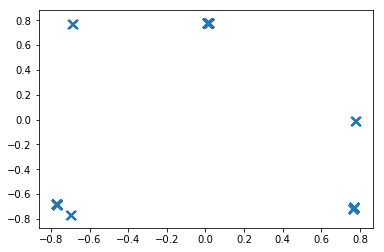

In [5]:
np.random.seed(0)

def get_cluster_centers(X, k, loops):
    kmeans = KMeans(k, n_jobs=-1, init='random')    
    # n_jobs=-1 tells it to use all available CPUs

    allclusters = []
    for i in range(loops):
        kmeans.fit(X)
        centers = kmeans.cluster_centers_
        for c in centers:
            allclusters.append(c)

    x_ac = [p[0] for p in allclusters]
    y_ac = [p[1] for p in allclusters]
    return (x_ac, y_ac)

(x_ac, y_ac) = get_cluster_centers(X, 3, 100)

plt.scatter(x_ac, y_ac, marker='x', s=80)

## So now we have two problems

First, the solution is random, and second, rerunning k-means isn't displaying the random behaviour, suggesting actually a very stable solution.

Knowing that the solution is random, we should find a KPI of some kind, that correctly reports that this is so.
One solution is to apply a variant of k-fold cross validation. Using for instance 5 folds, the idea is normally to split the data into 5 chunks and run the clustering 5 times, each time on 80% of the data but a different subset of the sample. Unfortunately, we observe that using 80% of the data, the clustering remains equally stable. But this changes if we run on 20% instead: Running first on the first 20%, then on the second 20%, and so on.

The higher the number of folds, the more reliably we can demonstrate randomness, but if we choose too many folds, for example 1000, in this case we would only have 10 points left per clustering, and using 3 clusters we would expect the results to show random results even if the underlying distributions contain three clusters.

## Using Folds to Bring out the Randomness

We split the data into 10 folds and cluster each fold individually. Behold randomness:

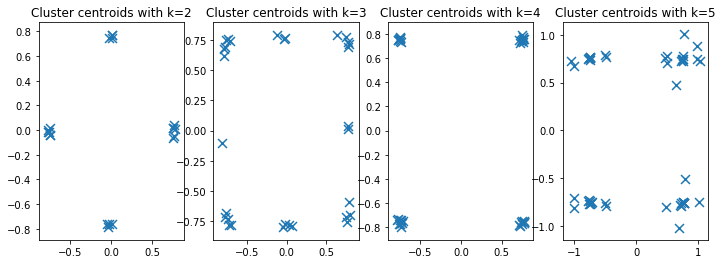

In [6]:
from sklearn.model_selection import KFold

np.random.seed(0)

n_clusters = 3
n_splits = 10

def get_clusters_using_folds(X, n_clusters, n_splits):
    kfold = KFold(n_splits=n_splits)
    x_ac = []
    y_ac = []
    for train_index, test_index in kfold.split(X):
        (x_fold, y_fold) = get_cluster_centers(X[test_index], k=n_clusters, loops=1)
        for x in x_fold:
            x_ac.append(x)
        for y in y_fold:
            y_ac.append(y)
    return (x_ac, y_ac)

plt.figure(1, figsize=(12, 4))

for i in range(4):
    k = 2 + i

    plt.subplot(141 + i)
    plt.title("Cluster centroids with k=" + str(k))
    (x_wfolds, y_wfolds) = get_clusters_using_folds(X, k, n_splits)
    plt.scatter(x_wfolds, y_wfolds, marker='x', s=80)

In the plot where we have clustered with k=3 we finally see the behaviour that we expected from the underlying distributions: There are cluster centers in each of the corners, as well between each of the clusters at approximately (0, -0.8), (0, 0.8), (0.8, 0) and (0, -0.8).

When clustering with the correct number of clusters (4), we see no randomness as expected.

## Quantifying Randomness

It's clear visually that the plot of cluster centroids using k=3 (3 clusters) does not correspond to a stable solution, and k=4, does. How to put a number on that?

I suggest to run k-means again on the cluster centroids. With k=4 and 10 folds, we will have calculated 40 different cluster centroids. If we cluster these 40 centroids again with k=4, we will find 4 very compact clusters, indicating that k=4 is right for this dataset. If we do the same on the 30 clusters that were generated with k=3, we find 3 clusters that are not compact and not well separated. After clustering the cluster centroids, we can look at two measures:

* "Cluster stability": The score of the k-means algorithm when run on the centroids (the objective of k-means, related to the cluster compactness).
* "Cluster confidence": The number of cluster centroids in each cluster. If we generated the cluster centroids using 10 folds, then after clustering the centroids, each cluster of centroids should contain 10 points, indicating that each cluster is found every time. To measure this we can look at the variance on the number of times each cluster is found.

One can argue that both these KPIs are defined the wrong way around: Both for the stability and the confidence, low values are better, which is contrary to what the name suggests. Sorry about that.

We can now plot these measures, cluster stability and cluster confidence, as a function of k (the number of clusters). A traditional method is the "elbow method" which looks at the k-means score after clustering the data points directly, for different values of k.

In [7]:
from collections import Counter

k_arr = [k+1 for k in range(10)]

def get_stability_and_confidence_k(X, k, n_splits):
    # Generate cluster centroids using folds:
    (xkx, xky) = get_clusters_using_folds(X, k, n_splits)
    Xk = np.array([xkx, xky]).T
    
    # Run k-means again on cluster centroids:
    kmeans = KMeans(k, n_jobs=-1, init='random')
    clusters = kmeans.fit_predict(Xk)
    
    # Calculate KPIs
    stability = -kmeans.score(Xk) 
    hist = np.histogram(clusters, bins=k)
    confidence = np.var(list(Counter(clusters).values()))
    return (stability, confidence)

def get_stability_and_confidence(X, k_arr, n_splits):
    stabs = []
    confs = []
    for k in k_arr:
        (s, c) = get_stability_and_confidence_k(X, k, n_splits)
        print("k=%2d: Stab=%7.2f Conf=%5.2f" % (k, s, c))
        stabs.append(s)
        confs.append(c)
    return (stabs, confs)

(stabs, confs) = get_stability_and_confidence(X, k_arr, n_splits)

k= 1: Stab=   0.01 Conf= 0.00
k= 2: Stab=   5.44 Conf= 0.00
k= 3: Stab=   7.12 Conf= 0.67
k= 4: Stab=   0.02 Conf= 0.00
k= 5: Stab=   1.16 Conf=12.80
k= 6: Stab=   1.95 Conf=15.00
k= 7: Stab=   2.48 Conf=11.43
k= 8: Stab=   2.86 Conf= 4.00
k= 9: Stab=   3.46 Conf= 9.11
k=10: Stab=   3.17 Conf= 3.80


In [8]:
def get_elbow_scores(X, k_arr):
    elbow_scores = []
    for k in k_arr:
        kmeans = KMeans(k, init='random')
        kmeans.fit(X)
        elbow_scores.append(-kmeans.score(X))
    return elbow_scores

elbow_scores = get_elbow_scores(X, k_arr)

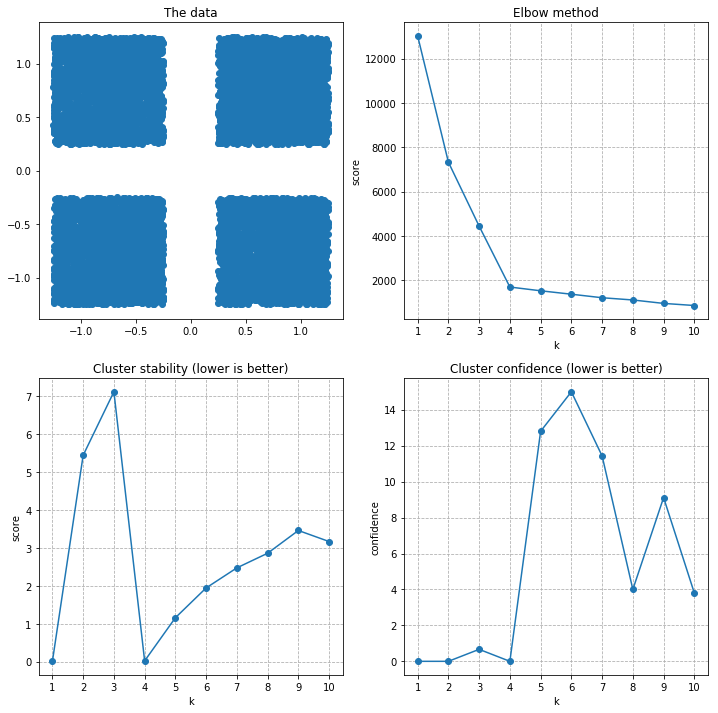

In [10]:
def plot_result(k_arr, x, y, colors, stabs, confs, elbow_scores):
    plt.figure(1, figsize=(12, 12))
    
    plt.subplot(221)
    plt.scatter(x,y, c=colors)
    plt.title('The data')
    
    plt.subplot(222)
    plt.plot(k_arr,elbow_scores, marker='o')
    plt.title('Elbow method')
    plt.xlabel('k')
    plt.ylabel('score')
    plt.xticks(k_arr)
    plt.grid(b=True, which='major', linestyle='--')
    
    plt.subplot(223)
    plt.plot(k_arr, stabs, marker='o')
    plt.title('Cluster stability (lower is better)')
    plt.xlabel('k')
    plt.ylabel('score')
    plt.xticks(k_arr)
    plt.grid(b=True, which='major', linestyle='--')
    
    plt.subplot(224)
    plt.plot(k_arr, confs, marker='o')
    plt.title('Cluster confidence (lower is better)')
    plt.xlabel('k')
    plt.ylabel('confidence')
    plt.xticks(k_arr)
    plt.grid(b=True, which='major', linestyle='--')
    
plot_result(k_arr, x, y, None, stabs, confs, elbow_scores)

These results show that for this data, we get both good stability and good confidence (low values for both) for the trivial solution (1 cluster) and for the solution with 4 clusters. The elbow method also idicates the correct number of clusters.


## Does it work on real data?

Let's try this on a few datasets that are a bit more realistic.

### The Iris Dataset

The Iris dataset is a well-known dataset with plant measurements, 4 measurements per plant from 3 different types of plants. There are 50 measurements of each type.

Hopefully our method will indicate 3 clusters in this data. To visualize the data I apply PCA down to 2 dimensions. It only has a 150 examples, so I'll be using 5 folds.

k= 1: Stab=   4.14 Conf= 0.00
k= 2: Stab=   5.81 Conf= 4.00
k= 3: Stab=   6.78 Conf= 0.67
k= 4: Stab=  10.85 Conf= 4.00
k= 5: Stab=   8.12 Conf= 5.20
k= 6: Stab=  10.27 Conf= 9.33
k= 7: Stab=  10.29 Conf= 5.71
k= 8: Stab=   9.62 Conf= 5.75
k= 9: Stab=   9.51 Conf= 7.11
k=10: Stab=   8.49 Conf= 5.60


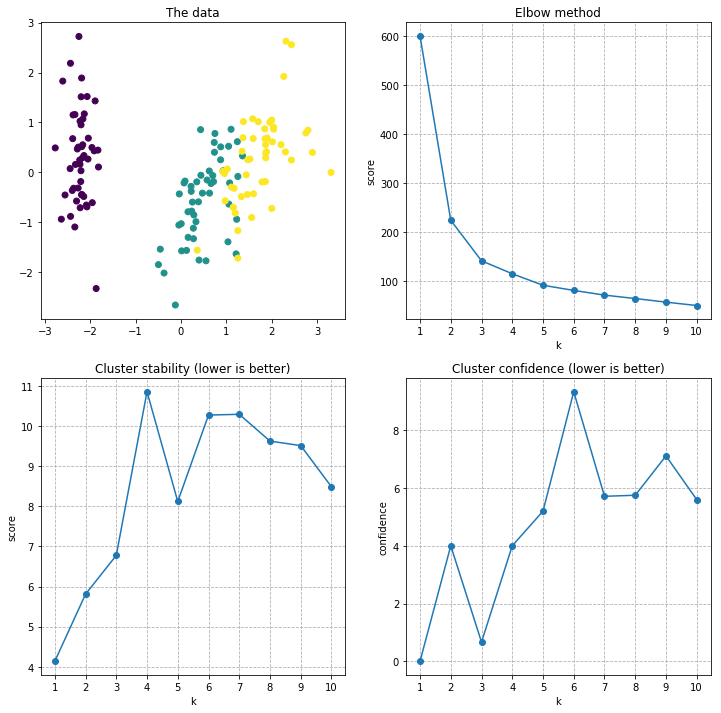

In [11]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

np.random.seed(0)

(data, target) = load_iris(return_X_y=True)
X = scale(data)

X_pca = PCA(n_components=2).fit_transform(X)
x = [x[0] for x in X_pca]
y = [x[1] for x in X_pca]

(stabs, confs) = get_stability_and_confidence(X, k_arr, n_splits=5)
elbow_scores = get_elbow_scores(X, k_arr)

plot_result(k_arr, x, y, target, stabs, confs, elbow_scores)

I have trouble applying my method to this dataset because of the limited statistics. My impression from the 2-dimensional visualization of the data is that 2 clusters might be good, but the confidence plot shows that the identified clusters are not always the same ones. I won't argue that the case for 3 clusters is obvious from these plots, but 3 clusters does appear to be a reasonable solution.

The elbow method does not show a clear kink.

### The MNIST Digits Dataset

The MNIST dataset is a collection of 8x8 images of hand-written digits, where each digit is a gray-scale from 0 to 16. There are 1797 images in the dataset and 64 features, which is a lot for a clustering algorithm due to the curse of dimensionality. I will therefore again apply PCA to reduce the dimension of the data before clustering.

I will apply the UMAP algorithm to create a 2-dimensional visualization. UMAP is similar in application to t-SNE, but in my experience it's faster and provides better separation. UMAP is a way to project high-dimensional features into a lower-dimensional space by creating a curved surface in the high-dimensional space. 

k= 1: Stab=   1.68 Conf= 0.00
k= 2: Stab=  82.86 Conf= 0.00
k= 3: Stab=  73.09 Conf=16.67
k= 4: Stab=  81.56 Conf=22.50
k= 5: Stab= 110.47 Conf=21.20
k= 6: Stab= 101.48 Conf=26.33
k= 7: Stab= 103.64 Conf=16.00
k= 8: Stab= 125.35 Conf=16.75
k= 9: Stab= 118.96 Conf= 9.11
k=10: Stab= 113.45 Conf= 6.80
k=11: Stab=  98.75 Conf=18.91
k=12: Stab= 117.02 Conf=10.33
k=13: Stab= 133.89 Conf=21.08
k=14: Stab= 126.34 Conf=10.86
k=15: Stab= 119.43 Conf=13.47
k=16: Stab= 124.75 Conf=15.12
k=17: Stab= 135.53 Conf=25.06
k=18: Stab= 145.53 Conf=25.89
k=19: Stab= 128.65 Conf=19.47
k=20: Stab= 140.20 Conf=22.90


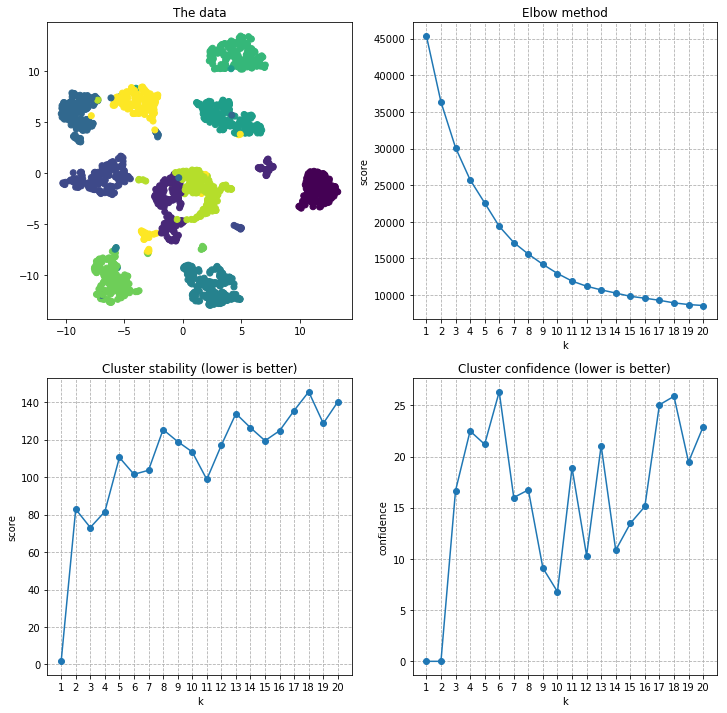

In [12]:
from sklearn.datasets import load_digits
from umap import UMAP

np.random.seed(0)

(data, target) = load_digits(return_X_y=True)

umapper = UMAP(n_neighbors=5, min_dist=0.3, metric='correlation')
vizdata = umapper.fit_transform(data)
x = [x[0] for x in vizdata]
y = [x[1] for x in vizdata]

X = PCA(n_components=5).fit_transform(scale(data))

k_arr = [k+1 for k in range(20)]

(stabs, confs) = get_stability_and_confidence(X, k_arr, n_splits=10)
elbow_scores = get_elbow_scores(X, k_arr)

plot_result(k_arr, x, y, target, stabs, confs, elbow_scores)

It may be surprising that it works at all to interpret each image as a 64 dimensional vector and cluster them, since the exact same digit translated across the image by one pixel produces an entirely different vector. But it works because the pixels are relatively large.

Since there are 10 digits in the data, one would hope to find 10 clusters.

In this example I basically blindly applied the algorithm and there is no particular reason to use PCA to go down to 5 dimensions. Clustering in 5 dimensions favours approximately clusters, with 9 clusters having the better "confidence" (always find the same ones) and 11 clusters the better "stability" (more stable centroids). Using other values than 5 works for PCA works more or less the same way. 

The elbow method does not appear very useful for this case.

## Conclusions

The fact that a clustering algorithm identifies clusters, does not mean these clusters have any significance. Using the idea of k-fold cross-validation, randomness can be generated in the clustering solutions, if the clusterings are artificial. Using the stability and confidence as defined proves useful to identify meaningful clusterings, and it scales well to large datasets.

The traditional elbow method often proves useless on practical datasets. Other approaches use clustering evaluation metrics to understand the quality of a clustering, such as the Silhouette score. These metrics often do not evaluate the question if other clusterings are equally valid and often do not scale well with to large numbers of samples.

In a [later notebook called "Clustering Quality Metrics"](https://github.com/pbalm/mlbits/blob/master/Clustering%20Quality%20Metrics.ipynb) I compare how well the Silhouette index and the Adjusted Rand Index hold up against this task.